# Spatial Domain Image Smoothing & Noise Reduction

This notebook explores various spatial filters implemented from scratch. 

### Filters Implemented:
1.  **Mean Filter**: Simple averaging.
2.  **Weighted Mean**: Center-heavy averaging.
3.  **Gaussian Filter**: Normal distribution weights ($\sigma=1, 3$).
4.  **Median Filter**: Non-linear rank-order filter.
5.  **Bilateral Filter**: Edge-preserving smoothing using spatial and intensity kernels.

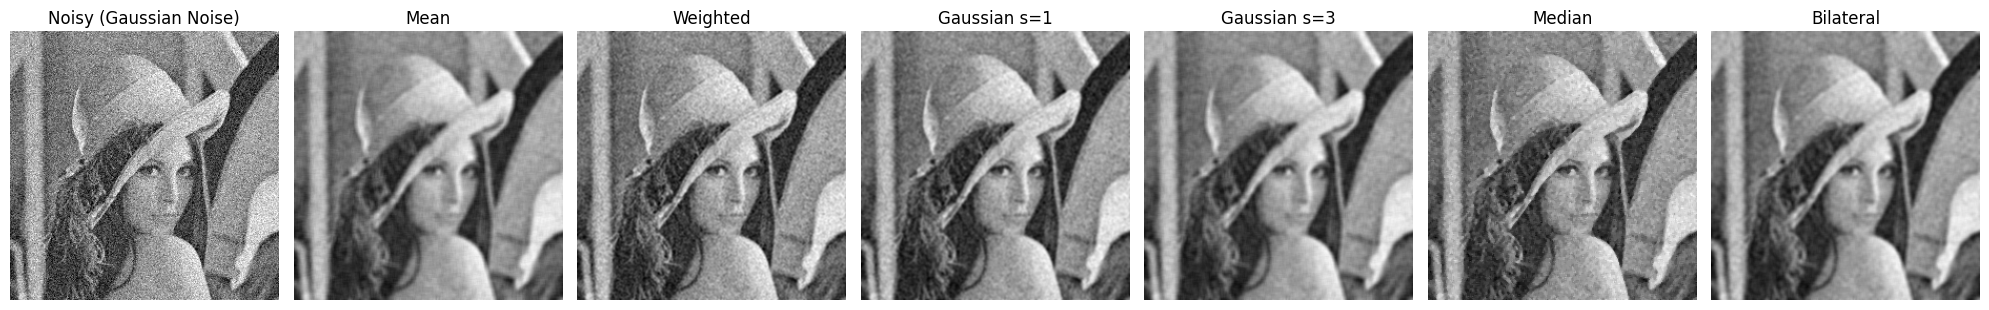

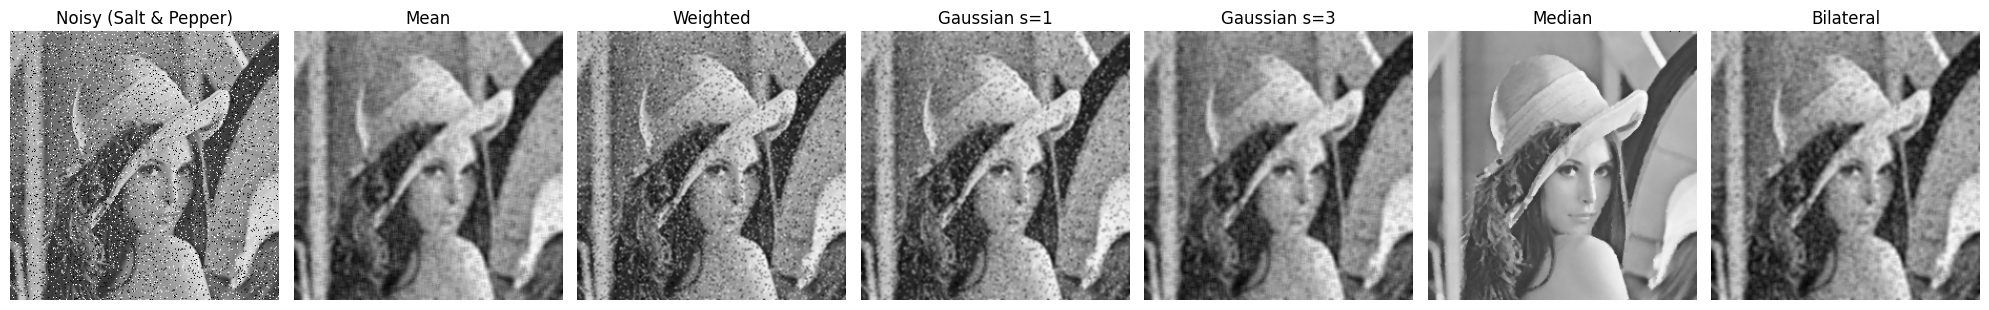

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- NOISE GENERATORS ---

def add_gaussian_noise(image, sigma=25):
    gauss = np.random.normal(0, sigma, image.shape)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_salt_and_pepper(image, prob=0.05):
    noisy = np.copy(image)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                noisy[i, j] = 0
            elif rdn > thres:
                noisy[i, j] = 255
    return noisy

# --- MANUAL FILTER IMPLEMENTATIONS ---

def convolve2d(image, kernel):
    ih, iw = image.shape
    kh, kw = kernel.shape
    pad = kh // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image, dtype=np.float32)
    
    for i in range(ih):
        for j in range(iw):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
    return np.clip(output, 0, 255).astype(np.uint8)

def manual_median(image, size=3):
    ih, iw = image.shape
    pad = size // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    
    for i in range(ih):
        for j in range(iw):
            region = padded[i:i+size, j:j+size]
            output[i, j] = np.median(region)
    return output

def manual_bilateral(image, size=5, sigma_d=2.0, sigma_r=30.0):
    ih, iw = image.shape
    pad = size // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image, dtype=np.float32)
    
    x, y = np.mgrid[-pad:pad+1, -pad:pad+1]
    spatial_gauss = np.exp(-(x**2 + y**2) / (2 * sigma_d**2))

    for i in range(ih):
        for j in range(iw):
            roi = padded[i:i+size, j:j+size]
            intensity_diff = roi - padded[i+pad, j+pad]
            range_gauss = np.exp(-(intensity_diff**2) / (2 * sigma_r**2))
            
            weights = spatial_gauss * range_gauss
            weights /= np.sum(weights)
            output[i, j] = np.sum(roi * weights)
            
    return output.astype(np.uint8)

def get_gaussian_kernel(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

# --- PIPELINE EXECUTION ---

# 1. Load Image
img = cv2.imread('input.png', 0)

#if img is None: img = (np.indices((256, 256))[0] + np.indices((256, 256))[1]).astype(np.uint8)

img = cv2.resize(img, (256, 256))

# 2. Create Noisy Versions
img_gauss = add_gaussian_noise(img)
img_sp = add_salt_and_pepper(img)

def run_all_filters(src):
    return {
        'Mean': convolve2d(src, np.ones((5,5))/25),
        'Weighted': convolve2d(src, np.array([[1,2,1],[2,4,2],[1,2,1]])/16),
        'Gaussian s=1': convolve2d(src, get_gaussian_kernel(5, 1)),
        'Gaussian s=3': convolve2d(src, get_gaussian_kernel(5, 3)),
        'Median': manual_median(src, 3),
        'Bilateral': manual_bilateral(src)
    }

res_gauss = run_all_filters(img_gauss)
res_sp = run_all_filters(img_sp)

# --- VISUALIZATION ---

def plot_comparison(noisy_img, results, title):
    keys = list(results.keys())
    plt.figure(figsize=(20, 4))
    plt.subplot(1, len(keys)+1, 1)
    plt.imshow(noisy_img, cmap='gray'), plt.title(f'Noisy ({title})'), plt.axis('off')
    
    for i, name in enumerate(keys):
        plt.subplot(1, len(keys)+1, i+2)
        plt.imshow(results[name], cmap='gray'), plt.title(name), plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_comparison(img_gauss, res_gauss, 'Gaussian Noise')
plot_comparison(img_sp, res_sp, 'Salt & Pepper')

In [3]:
def calculate_metrics(original, processed):
    # MSE: Lower is better (closer to original)
    mse = np.mean((original.astype(np.float32) - processed.astype(np.float32))**2)
    if mse == 0:
        return 0.0, 100.0
    # PSNR: Higher is better (less noise)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return mse, psnr

def display_metrics_table(original, results_gauss, results_sp):
    print(f"{'Filter Type':<15} | {'Gauss MSE':<10} | {'Gauss PSNR':<10} | {'S&P MSE':<10} | {'S&P PSNR':<10}")
    print("-" * 70)
    
    for name in results_gauss.keys():
        mse_g, psnr_g = calculate_metrics(original, results_gauss[name])
        mse_s, psnr_s = calculate_metrics(original, results_sp[name])
        print(f"{name:<15} | {mse_g:<10.2f} | {psnr_g:<10.2f} | {mse_s:<10.2f} | {psnr_s:<10.2f}")

# Execute comparison
display_metrics_table(img, res_gauss, res_sp)

Filter Type     | Gauss MSE  | Gauss PSNR | S&P MSE    | S&P PSNR  
----------------------------------------------------------------------
Mean            | 140.53     | 26.65      | 220.76     | 24.69     
Weighted        | 121.91     | 27.27      | 317.66     | 23.11     
Gaussian s=1    | 105.83     | 27.88      | 234.41     | 24.43     
Gaussian s=3    | 132.07     | 26.92      | 212.84     | 24.85     
Median          | 149.54     | 26.38      | 41.31      | 31.97     
Bilateral       | 123.59     | 27.21      | 200.40     | 25.11     


### Performance Analysis

1. **Gaussian Noise**: Linear filters (Gaussian, Mean) perform reasonably well, but the **Bilateral Filter** provides the best balance between reducing graininess and keeping edges sharp. 
2. **Salt & Pepper Noise**: Linear filters (Mean, Gaussian) fail significantly here, spreading the black/white pixels into grey smudges. The **Median Filter** is the clear winner, as it completely eradicates outliers.
3. **Computational Cost**: Bilateral is the most expensive ($O(N \cdot K^2)$), followed by Median (requires sorting or partition per window).